# Nb-20180319-1218-RandomForest-GainPrediction

In [5]:
STAMP = "20180319-1218"

This is a modification of the previous notebook.

Do a simple random forest to try to predict if a stock ticker will make a gain the next day.

- Adding 'Adj Low' history didn't seem helpful, remove it
- Add in booleans for 'Open Higher Than Close', etc. 

In [6]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [7]:
from collections import defaultdict
import operator

In [8]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [9]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [10]:
import finance as fat

In [11]:
# Change the plot size.
plt.rcParams['figure.figsize'] = [18.0, 10.0]

In [12]:
tickers = ['AAPL', 'FB', 'IBM', 'GOOG', 'MSFT','AMZN','CSCO','INTC']

In [43]:
def create_ml_ticker_features_df(ticker, update=True) :
    data = fat.get_price_data(ticker, update)
    
    # check for required columns in data
    for c in ['Open','High','Low','Close','Adj Close', 'Volume'] :
        assert c in data.columns, f'{ticker} does not contain data for {c}'

    # Price features
    data = adjust_ohlc_prices(data)
    
    for c in ['Adj Close'] :
        data = add_history(data, c, range(-5, 0))
        data = fat.add_sma_columns(data, c, [6,12,20,200])
        data = fat.add_ema_columns(data, c, [3,6,12,26,50])
        data = fat.add_bollinger_bands(data, c)
    
    data = scale_columns(data, 1.0/data['Adj Close'], column_contains='Adj')
    
    # 'Adj Close' data has all been scaled to 1.0, so get rid of it
    del data['Adj Close']
    # data = add_ohlc_booleans(data)

    data['Close Higher than Open'] = data['Adj Open'] < 1
    data['Close Lower than Open'] = data['Adj Open'] > 1

    zero_err = .00001
    data['High was Open'] = abs(data['Adj High'] - data['Adj Open']) < zero_err
    data['High was Close'] = abs(data['Adj High'] - 1) < zero_err
    data['Low was Open'] = abs(data['Adj Low'] - data['Adj Open']) < zero_err
    data['Low was Close'] = abs(data['Adj Low'] - 1) < zero_err

    data['Closed Higher than Prev Close'] = data['Adj Close -1d'] < 1
    data['Closed Lower than Prev Close'] = data['Adj Close -1d'] > 1
    
    # Volume features
    # ... first, replace 0's with 1's so we don't divide by zero when scaling (some data has 0's in volume)
    data['Volume'] = data['Volume'].replace(0, 1)
    data = add_history(data, 'Volume', range(-5, 0))
    #data = fat.add_bollinger_bands(data, 'Volume')
    data = scale_columns(data, 1.0/data['Volume'], column_contains='Volume')
    # 'Volume' data has all been scaled to 1.0, so get rid of it
    del data['Volume']
    
    return data

In [44]:
def adjust_ohlc_prices(data_frame, inplace=False) :
    assert isinstance(data_frame, pd.DataFrame), \
        "data_frame must be pandas.DataFrame object"
    
    df = fat.use_data_frame_if_inplace(data_frame, inplace)
    
    columns = ['Open', 'High', 'Low', 'Close']
    scaling = df['Close'] / df['Adj Close']
    for c in columns :
        df[c] /= scaling
    
    del df['Adj Close']
    
    # rename columns, add 'Adj ' to name
    new_cols = {c : ('Adj '+c) for c in columns}
    df.rename(columns=new_cols, inplace=True)
    return df

In [45]:
def add_history(data_frame, column, day_range, inplace=False) :
    assert isinstance(data_frame, pd.DataFrame), \
        "data_frame must be pandas.DataFrame object"
    df = fat.use_data_frame_if_inplace(data_frame, inplace)
    
    for i in day_range :
        df[f'{column} {i}d'] = df[column].shift(-i)
    return df

In [46]:
def scale_columns(data_frame, scaling, column_contains, inplace=False) :
    assert isinstance(data_frame, pd.DataFrame), \
        "data_frame must be pandas.DataFrame object"
    df = fat.use_data_frame_if_inplace(data_frame, inplace)
    
    for c in df.columns : 
        if column_contains in c :
            df[c] *= scaling
    return df

In [47]:
def add_ticker(data_frame, ticker) :
    assert isinstance(data_frame, pd.DataFrame), \
        "data_frame must be pandas.DataFrame object"
    df = data_frame.copy()
    
    df['Ticker'] = ticker
    
    # ... and rearrange columns to put ticker in front 
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    
    return df

In [48]:
d = fat.get_price_data('AAPL', update=False)
d[:10]

Loaded data for AAPL: 1980-12-12 to 2018-03-16.


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.023357,117258400.0
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.022139,43971200.0
1980-12-16,0.453125,0.453125,0.450893,0.450893,0.020514,26432000.0
1980-12-17,0.462054,0.464286,0.462054,0.462054,0.021022,21610400.0
1980-12-18,0.475446,0.477679,0.475446,0.475446,0.021631,18362400.0
1980-12-19,0.504464,0.506696,0.504464,0.504464,0.022951,12157600.0
1980-12-22,0.529018,0.531250,0.529018,0.529018,0.024068,9340800.0
1980-12-23,0.551339,0.553571,0.551339,0.551339,0.025084,11737600.0
1980-12-24,0.580357,0.582589,0.580357,0.580357,0.026404,12000800.0


In [49]:
d = create_ml_ticker_features_df('AAPL', update=False)
d = d.dropna()
d[:10]

Loaded data for AAPL: 1980-12-12 to 2018-03-16.


,Adj Open,Adj High,Adj Low,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Adj Close SMA6,Adj Close SMA12,...,High was Close,Low was Open,Low was Close,Closed Higher than Prev Close,Closed Lower than Prev Close,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d
Date,,,,,,,,,,,,,,,,,,,,,
1981-09-29,1.000000,1.008264,1.0,1.115723,1.090902,1.082682,0.942139,0.950439,1.030314,1.115017,...,False,True,True,True,False,0.500828,0.297847,0.193281,0.365507,0.968772
1981-09-30,1.000000,1.008200,1.0,1.081921,1.073769,0.934383,0.942615,0.991768,1.004076,1.085351,...,False,True,True,True,False,0.564068,0.366039,0.692204,1.834677,1.893817
1981-10-01,1.000000,1.008200,1.0,1.073769,0.934383,0.942615,0.991768,1.000000,0.990422,1.067595,...,False,True,True,False,False,0.299377,0.566141,1.500550,1.548919,0.817882
1981-10-02,1.000000,1.007575,1.0,0.863633,0.871242,0.916673,0.924282,0.924282,0.916685,0.978553,...,False,True,True,True,False,0.768274,2.036300,2.101939,1.109896,1.357036
1981-10-05,1.000000,1.014708,1.0,0.845630,0.889726,0.897111,0.897111,0.970603,0.916697,0.946721,...,False,True,True,True,False,2.128378,2.196985,1.160083,1.418399,1.045218
1981-10-06,1.007407,1.007407,1.0,0.896280,0.903720,0.903720,0.977753,1.007367,0.948140,0.949374,...,False,False,True,False,True,3.338863,1.763033,2.155608,1.588468,1.519747
1981-10-07,1.000000,1.013988,1.0,0.853188,0.853188,0.923082,0.951040,0.944085,0.920764,0.896290,...,False,True,True,True,False,1.287197,1.573818,1.159746,1.109573,0.730104
1981-10-08,1.000000,1.006756,1.0,0.824351,0.891883,0.918896,0.912176,0.966201,0.918918,0.873314,...,False,True,True,True,False,1.966138,1.448847,1.386167,0.912104,1.249280
1981-10-09,1.000000,1.013425,1.0,0.885871,0.912702,0.906027,0.959688,0.993259,0.942924,0.876938,...,False,True,True,True,False,0.826212,0.790468,0.520131,0.712408,0.570255


In [53]:
d = fat.create_ml_features_df(d)
d[:10].T

Date,1981-09-29 00:00:00,1981-09-30 00:00:00,1981-10-01 00:00:00,1981-10-02 00:00:00,1981-10-05 00:00:00,1981-10-06 00:00:00,1981-10-07 00:00:00,1981-10-08 00:00:00,1981-10-09 00:00:00,1981-10-12 00:00:00
Adj Open,1,1,1,1,1,1.00741,1,1,1,1
Adj High,1.00826,1.0082,1.0082,1.00758,1.01471,1.00741,1.01399,1.00676,1.01342,1.00649
Adj Low,1,1,1,1,1,1,1,1,1,1
Adj Close -5d,1.11572,1.08192,1.07377,0.863633,0.84563,0.89628,0.853188,0.824351,0.885871,0.883113
Adj Close -4d,1.0909,1.07377,0.934383,0.871242,0.889726,0.90372,0.853188,0.891883,0.912702,0.876655
Adj Close -3d,1.08268,0.934383,0.942615,0.916673,0.897111,0.90372,0.923082,0.918896,0.906027,0.928576
Adj Close -2d,0.942139,0.942615,0.991768,0.924282,0.897111,0.977753,0.95104,0.912176,0.959688,0.961059
Adj Close -1d,0.950439,0.991768,1,0.924282,0.970603,1.00737,0.944085,0.966201,0.993259,0.967581
Adj Close SMA6,1.03031,1.00408,0.990422,0.916685,0.916697,0.94814,0.920764,0.918918,0.942924,0.936164
Adj Close SMA12,1.11502,1.08535,1.06759,0.978553,0.946721,0.949374,0.89629,0.873314,0.876938,0.860951


In [54]:
data_raw = None
for t in tickers :
    df = create_ml_ticker_features_df(t, update=False)
    df = fat.create_ml_features_df(df)
    df = add_ticker(df, t)
    
    df['Gain +1d'] = df['Adj Open'].shift(-1) < 1.0
    
    data_raw = df.append(data_raw)        

Loaded data for AAPL: 1980-12-12 to 2018-03-16.
Loaded data for FB: 2012-05-18 to 2018-03-16.
Loaded data for IBM: 1970-01-02 to 2018-03-16.
Loaded data for GOOG: 2004-08-19 to 2018-03-16.
Loaded data for MSFT: 1986-03-13 to 2018-03-16.
Loaded data for AMZN: 1997-05-15 to 2018-03-16.
Loaded data for CSCO: 1990-02-16 to 2018-03-16.
Loaded data for INTC: 1980-03-17 to 2018-03-16.


In [55]:
data_raw = data_raw.sort_index()
data_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Adj Open,56414.0,1.000257e+00,3.315315e-02,7.758007e-01,9.903894e-01,1.000000e+00,1.009569e+00,7.057778e+00
Adj High,56414.0,1.014105e+00,3.018389e-02,1.000000e+00,1.004179e+00,1.009274e+00,1.018258e+00,7.111111e+00
Adj Low,56414.0,9.860949e-01,1.527625e-02,7.711443e-01,9.815422e-01,9.905666e-01,9.958581e-01,1.000000e+00
Adj Close -5d,56374.0,9.976059e-01,5.640931e-02,5.791284e-01,9.698926e-01,9.960438e-01,1.022568e+00,2.424929e+00
Adj Close -4d,56382.0,9.980999e-01,5.058621e-02,5.705521e-01,9.734397e-01,9.970967e-01,1.020597e+00,2.264551e+00
Adj Close -3d,56390.0,9.985925e-01,4.413561e-02,6.283784e-01,9.776878e-01,9.978438e-01,1.017894e+00,2.397760e+00
Adj Close -2d,56398.0,9.990754e-01,3.626345e-02,6.766591e-01,9.823618e-01,9.988078e-01,1.014925e+00,2.206186e+00
Adj Close -1d,56406.0,9.995369e-01,2.551866e-02,7.436527e-01,9.881431e-01,1.000000e+00,1.010467e+00,2.077671e+00
Adj Close SMA6,56374.0,9.988107e-01,3.127293e-02,7.519628e-01,9.837956e-01,9.981104e-01,1.012444e+00,1.846683e+00
Adj Close SMA12,56326.0,9.973297e-01,4.705561e-02,6.572091e-01,9.736846e-01,9.956737e-01,1.017968e+00,2.129611e+00


In [57]:
data_raw.tail().T

Date,2018-03-16 00:00:00,2018-03-16 00:00:00,2018-03-16 00:00:00,2018-03-16 00:00:00,2018-03-16 00:00:00
Ticker,AMZN,MSFT,FB,IBM,AAPL
Adj Open,1.00749,1.00085,0.996758,0.998752,1.00354
Adj High,1.0113,1.00825,1.0013,1.01073,1.00618
Adj Low,0.99734,0.992812,0.990923,0.996131,0.997753
Adj Close -5d,1.00459,1.02051,1.00076,0.994072,1.01101
Adj Close -4d,1.01699,1.02294,0.998217,1,1.02078
Adj Close -3d,1.0105,0.997992,0.982657,0.994135,1.01095
Adj Close -2d,1.01229,0.992072,0.995138,0.986647,1.00236
Adj Close -1d,1.00677,0.99556,0.993355,0.995944,1.00354
Adj Close SMA6,1.00852,1.00484,0.99502,0.995133,1.00811


In [58]:
data_raw = data_raw.dropna()

In [59]:
del data_raw['Elapsed']
del data_raw['Year']

In [60]:
train_cats(data_raw)

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [61]:
file_name = f'data/tmp/{STAMP}-gain-raw'

In [62]:
os.makedirs('data/tmp', exist_ok=True)
data_raw = data_raw.reset_index()
data_raw.to_feather(file_name)

### Pre-processing

In the future we can simply read it from this fast format.

In [63]:
df_raw = pd.read_feather(file_name)

In [64]:
df_raw = df_raw.set_index('Date')

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [65]:
dep_col = 'Gain +1d'

In [66]:
#train_start = '1990-01'
train_end = '2016-02'
valid_start = '2016-03'
valid_end = '2017-02'
test_start = '2017-03'

In [67]:
df, y, nas = proc_df(df_raw, dep_col)

In [68]:
df_train = df[:train_end]
df_valid = df[valid_start : valid_end]
df_test = df[test_start:]
print(f'train, valid, test sizes: {len(df_train)}, {len(df_valid)}, {len(df_test)}')

train, valid, test sizes: 50694, 2016, 2112


In [69]:
X_train = df_train
X_valid = df_valid
X_test = df_test
print(f'train, valid, test sizes: {len(X_train)}, {len(X_valid)}, {len(X_test)}')

train, valid, test sizes: 50694, 2016, 2112


In [70]:
y, train_end

(array([ True, False, False, ..., False, False, False]), '2016-02')

In [71]:
y_train = y[:len(X_train)]
y_valid = y[len(X_train)+1 : -len(X_test)+1]
y_test = y[-len(X_test):]
print(f'train, valid, test sizes: {len(y_train)}, {len(y_valid)}, {len(y_test)}')

train, valid, test sizes: 50694, 2016, 2112


# Random Forests

## Base model

Let's try our model again, this time with separate training and validation sets.

In [72]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [73]:
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=30, max_features='log2', n_jobs=-1, oob_score=True, random_state=42)
m.fit(X_train, y_train)
print_score(m)

[0.83175523730619, 0.49206349206349204, 0.5413461159111532]


In [74]:
y_pred = m.predict(X_valid)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[485, 425],
       [599, 507]], dtype=int64)

In [75]:
def plot_metrics(metrics): return metrics.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [76]:
def get_metrics(stamp, y_valid, y_pred, chance) :
    col = ['accuracy', 'precision','recall','f1','chance']
    val = []
    val.append(metrics.accuracy_score(y_valid, y_pred))
    val.append(metrics.precision_score(y_valid, y_pred))
    val.append(metrics.recall_score(y_valid, y_pred))
    val.append(metrics.f1_score(y_valid, y_pred))
    val.append(chance)
    
    return pd.DataFrame(data=[val], columns=col, index=[stamp])

In [77]:
# Percent of true gains over all samples: compare to precision -- precision should be signficantly higher if this is a useful
# prediction
# (cnf_matrix[1,0] + cnf_matrix[1,1]) / cnf_matrix.sum() 
chance = cnf_matrix[1:].sum() / cnf_matrix.sum()

In [78]:
met = get_metrics(STAMP, y_valid, y_pred, chance)

,accuracy,precision,recall,f1,chance
20180319-1218,0.492063,0.543991,0.458409,0.497547,0.548611


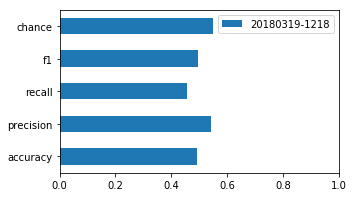

In [79]:
met.T.plot(kind='barh', figsize=(5,3), xlim=(0,1))
met

In [80]:
fi = rf_feat_importance(m, df)

In [81]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,12), legend=False)

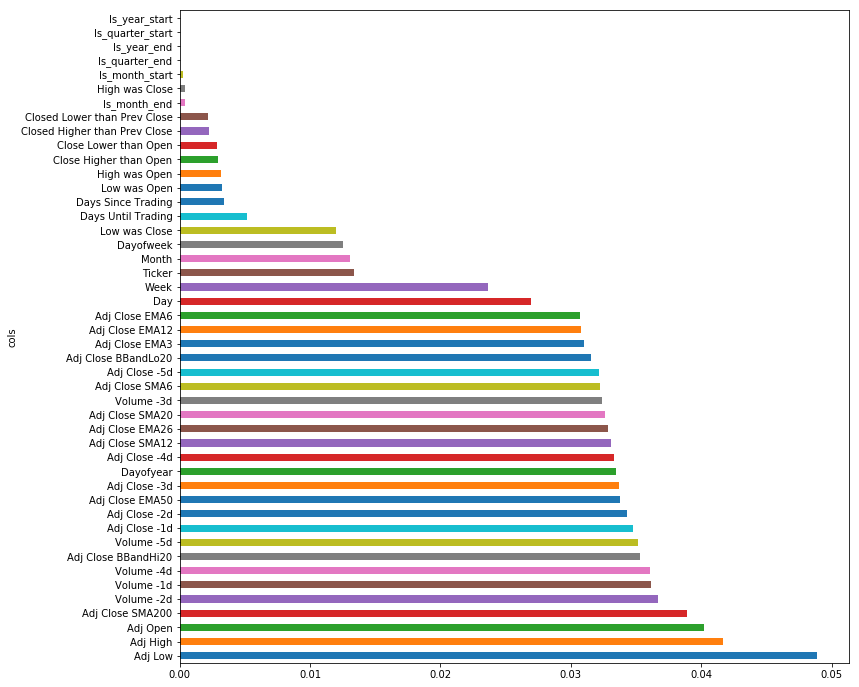

In [82]:
plot_fi(fi)

### Confidence

In [83]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 2.06 s


(0.34, 0.4737087712930805)

In [84]:
x = df_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)

In [85]:
x['Gain +1d'] = y_valid

In [86]:
conf_gain = x.loc[x['pred'] >= 0.7]
conf_gain = pd.DataFrame(conf_gain, columns=['Ticker','pred','pred_std', 'Gain +1d'])
print(f"{len(conf_gain)} {len(conf_gain.loc[conf_gain['Gain +1d'] == True])/len(conf_gain)}")

38 0.5526315789473685


In [87]:
conf_gain

,Ticker,pred,pred_std,Gain +1d
Date,,,,
2016-03-11,3,0.76,0.427083,True
2016-03-11,7,0.83,0.375633,True
2016-04-01,1,0.75,0.433013,False
2016-04-01,2,0.72,0.448999,False
2016-04-01,6,0.70,0.458258,True
2016-04-15,5,0.76,0.427083,True
2016-04-15,2,0.73,0.443959,False
2016-04-28,4,0.79,0.407308,False
2016-04-29,2,0.70,0.458258,True
